Testing aws api here and LLM


In [1]:
!pip install boto3 matplotlib

In [2]:
import boto3

# Bedrock client
bedrock = boto3.client(
    service_name="bedrock-runtime",
    region_name="us-east-1"  # or your region
)

In [3]:
# Simulated OCR output of student homework
homework_text = """
Describe an event which you did not look forward to attending but

turned out to exciting.

As a young teenager growing up in Singapore, I often found myself dreading certain
events or activities that my family and friends would plan. Whether it was a family
gathering, a school field trip, or a friend's birthday party, there were times when I just
did not feel like going. However, one particular event stands out in my memory as an
occasion where I surprised myself by having an unexpectedly great time.

It was a warm Saturday afternoon, and my mom had told me that we were going to
visit my great aunt who lived in a different part of the city. I was not particularly close
to my great aunt, and I did not really know what to expect from the visit. In fact, I was
feeling a bit grumpy and resentful about having to spend my weekend doing
something that I was not interested in. As we made our way to her house, I kept
thinking about all the other things I could have been doing instead.

When we arrived, my great aunt greeted us with a warm smile and a big hug. She
was a kind and gentle woman, and I immediately felt at ease in her company. As we
settled into her living room, she offered us some snacks and began to tell us stories
about her life. I was surprised to find that I was actually interested in what she had to
say, and I listened attentively as she shared her experiences growing up in
Singapore during a different era.

After a while, my greatest of aunt suggested that we take a walks around her
neighbourhood. I wasn't not sure what to expect, but I agreed to join her and my mom.
As we walked, my great aunt pointed out different landmarks and shared more
stories about her past. I found myself enjoying the walk, taking in the sights and

sounds of the neighborhood, and feeling grateful to be spending time with my family.
"""

In [ ]:
import json

#li loong is the lil bro

prompt_classify = f"""
<role>
You are an English tutor. 
A student submitted the following homework:
</role>

<homework>{homework_text}</homework>

<instructions>
Analyze the student's work and identify flaws in the homework regarding each of these categories, envelope within <analysis> tags:
- Grammar
- Vocabulary
- Writing
- Spelling
- Punctuation

Provide a strength index (1 to 5), envelope within <attribute> tags:
<example>
Grammar: 5
Vocabulary: 3
Writing: 2
Spelling: 1
Punctuation: 4
</example>
</instructions>
"""

response = bedrock.invoke_model(
    modelId="anthropic.claude-v2:1",
    body=json.dumps({
        "prompt": f"\n\nHuman: {prompt_classify}\n\nAssistant:",
        "max_tokens_to_sample": 300,
        "temperature": 0.3,
        "stop_sequences": ["\n\nHuman:"]
    })
)

result = json.loads(response["body"].read())
weakness_summary = result["completion"]
print("Weakness Classification:\n", weakness_summary)

Weakness Classification:
  <analysis>
Grammar: There are some grammatical errors such as incorrect verb tenses ("I wasn't not sure" instead of "I wasn't sure") and issues with subject-verb agreement ("my greatest of aunt" instead of "my great aunt").

Vocabulary: The vocabulary seems appropriate for the most part. No major issues.

Writing: The writing flows reasonably well, with a clear introduction, body, and conclusion. The sequence of events is logical. Some awkward phrasing in places.  

Spelling: There are a few spelling mistakes such as "greatest" instead of "great aunt" and "neighbourhood" instead of "neighborhood".

Punctuation: Occasional missing commas and periods. Generally decent punctuation.
</analysis>

<attribute> 
Grammar: 3
Vocabulary: 4 
Writing: 4
Spelling: 3
Punctuation: 4
</attribute>


In [13]:

# Extract <analysis> content
match = re.search(r"<analysis>(.*?)</analysis>", weakness_summary, re.DOTALL)
if match:
    feedback_lines = [line.strip() for line in match.group(1).splitlines() if line.strip()]
else:
    feedback_lines = []

# Convert to JSON
feedback_json = json.dumps({"feedback": feedback_lines}, indent=2)
feedback_json

'{\n  "feedback": [\n    "Grammar: There are some grammatical errors such as incorrect verb tenses (\\"I wasn\'t not sure\\" instead of \\"I wasn\'t sure\\") and issues with subject-verb agreement (\\"my greatest of aunt\\" instead of \\"my great aunt\\").",\n    "Vocabulary: The vocabulary seems appropriate for the most part. No major issues.",\n    "Writing: The writing flows reasonably well, with a clear introduction, body, and conclusion. The sequence of events is logical. Some awkward phrasing in places.",\n    "Spelling: There are a few spelling mistakes such as \\"greatest\\" instead of \\"great aunt\\" and \\"neighbourhood\\" instead of \\"neighborhood\\".",\n    "Punctuation: Occasional missing commas and periods. Generally decent punctuation."\n  ]\n}'

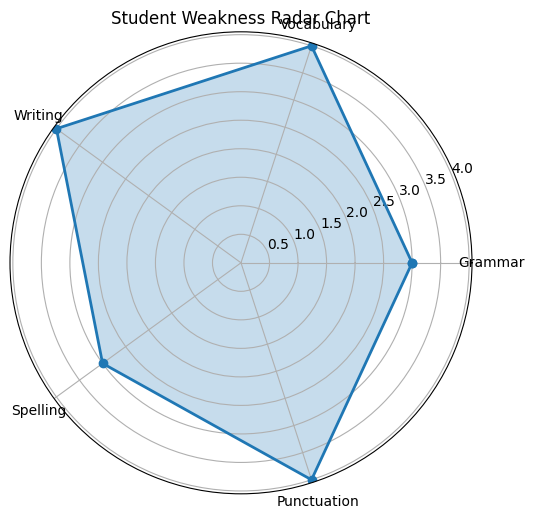

In [5]:
import sys
import os
sys.path.append(os.path.abspath("../utils"))

from generate_radar_chart import generate_radar_chart

generate_radar_chart(weakness_summary)


In [7]:
import json

prompt_exercises = f"""
You are an English tutor. Create 3 short exercises for a student with the following weaknesses:

{weakness_summary}

Return the exercises in **JSON format** like this:

{{
    "exercises": [
        {{
            "exercise": "First exercise text",
            "answer": "Answer to the first exercise"
        }},
        {{
            "exercise": "Second exercise text",
            "answer": "Answer to the second exercise"
        }},
        {{
            "exercise": "Third exercise text",
            "answer": "Answer to the third exercise"
        }}
    ]
}}
"""

response2 = bedrock.invoke_model(
    modelId="anthropic.claude-v2:1",
    body=json.dumps({
        "prompt": f"\n\nHuman: {prompt_exercises}\n\nAssistant:",
        "max_tokens_to_sample": 600,
        "temperature": 0.7,
        "stop_sequences": ["\n\nHuman:"]
    })
)

result2 = json.loads(response2["body"].read())
exercises_json_str = result2["completion"].strip()

# Convert to Python dict
try:
    exercises_data = json.loads(exercises_json_str)
except json.JSONDecodeError:
    # Sometimes Claude might add extra text; try to extract JSON with regex
    import re
    match = re.search(r"\{.*\}", exercises_json_str, re.DOTALL)
    exercises_data = json.loads(match.group()) if match else {}

# Print nicely
print(json.dumps(exercises_data, indent=2))


{
  "exercises": [
    {
      "exercise": "Fix the verb tense error in this sentence: 'Yesterday I wasn't not sure if I should go to the store.'",
      "answer": "Yesterday I wasn't sure if I should go to the store."
    },
    {
      "exercise": "Fix the subject-verb agreement error in this sentence: 'My greatest of aunt lived in my neighborhood when I was a child.'",
      "answer": "My great aunt lived in my neighborhood when I was a child."
    },
    {
      "exercise": "Add commas where needed in this sentence: 'My aunt who lived down the street always made chocolate chip cookies for me when I came to visit.'",
      "answer": "My aunt, who lived down the street, always made chocolate chip cookies for me when I came to visit."
    }
  ]
}
